# Basketball Playoffs Qualification

## Task description

Basketball tournaments are usually split in two parts. First, all teams play each other aiming to achieve the greatest number of wins possible. Then, at the end of the first part of the season, a pre determined number of teams which were able to win the most games are qualified to the playoff season, where they play series of knock-out matches for the trophy.

For the 10 years, data from players, teams, coaches, games and several other metrics were gathered and arranged on this dataset. The goal is to use this data to predict which teams will qualify for the playoffs in the next season.

## Data preparation

### Creating the database

First, we need to convert the CSV files to tables in an SQLite database, so we can analyze, manipulate and prepare data more easily. This was done with a couple of SQlite3 commands:

```
.mode csv
.import dataset/awards_players.csv awards_players
.import dataset/coaches.csv coaches
.import dataset/players.csv players
.import dataset/players_teams.csv players_teams
.import dataset/series_post.csv series_post
.import dataset/teams_post.csv teams_post
.import dataset/teams.csv teams
.save database.db
```

### Filtering unneeded rows and columns

Upon closer inspection of the dataset, we found some rows which had no effect or could have a negative impact in our models training, such as rows in the players table which corresponded to current coaches, and thus had no information related to their height, weight, etc.

## Model performance measures

### The Game Score measure
The Game Score measure, created by John Hollinger, attempts to give an estimation of a player's productivity for a single game. We will start working on our model based on this measure, applying it to each player based on a whole season's stats and dividing it by the amount of games played.

### Basketball Power Index


Import necessary packages

In [109]:
import sqlite3
import pandas as pd

Create dataframes based on the database and relations between data

In [110]:
con = sqlite3.connect("database.db")

# Player <-> Awards
pl_aw = pd.read_sql_query("SELECT * FROM awards_players INNER JOIN players ON awards_players.playerID = players.bioID", con)

# Player <-> Teams
pl_tm = pd.read_sql_query("SELECT * FROM players_teams INNER JOIN players ON players_teams.playerID = players.bioID", con)

# Teams <-> Post Season Results (aggregated)
tm_psa = pd.read_sql_query("SELECT * FROM teams_post INNER JOIN teams ON (teams_post.tmID = teams.tmID AND teams_post.year = teams.year)", con)

# Coach <-> Teams
cc_tm = pd.read_sql_query("SELECT * FROM coaches INNER JOIN teams ON (coaches.tmID = teams.tmID AND coaches.year = teams.year)", con)

print(cc_tm)


        coachID year tmID  lgID stint won lost post_wins post_losses year  \
0    adamsmi01w    5  WAS  WNBA     0  17   17         1           2    5   
1    adubari99w    1  NYL  WNBA     0  20   12         4           3    1   
2    adubari99w    2  NYL  WNBA     0  21   11         3           3    2   
3    adubari99w    3  NYL  WNBA     0  18   14         4           4    3   
4    adubari99w    4  NYL  WNBA     0  16   18         0           0    4   
..          ...  ...  ...   ...   ...  ..  ...       ...         ...  ...   
157  wintebr01w    6  IND  WNBA     0  21   13         2           2    6   
158  wintebr01w    7  IND  WNBA     0  21   13         0           2    7   
159  wintebr01w    8  IND  WNBA     0  21   13         3           3    8   
160  zierddo99w    8  MIN  WNBA     0  10   24         0           0    8   
161  zierddo99w    9  MIN  WNBA     0  16   18         0           0    9   

     ...  GP homeW homeL awayW awayL confW confL   min  attend  \
0    ... 

## Plots

In [111]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

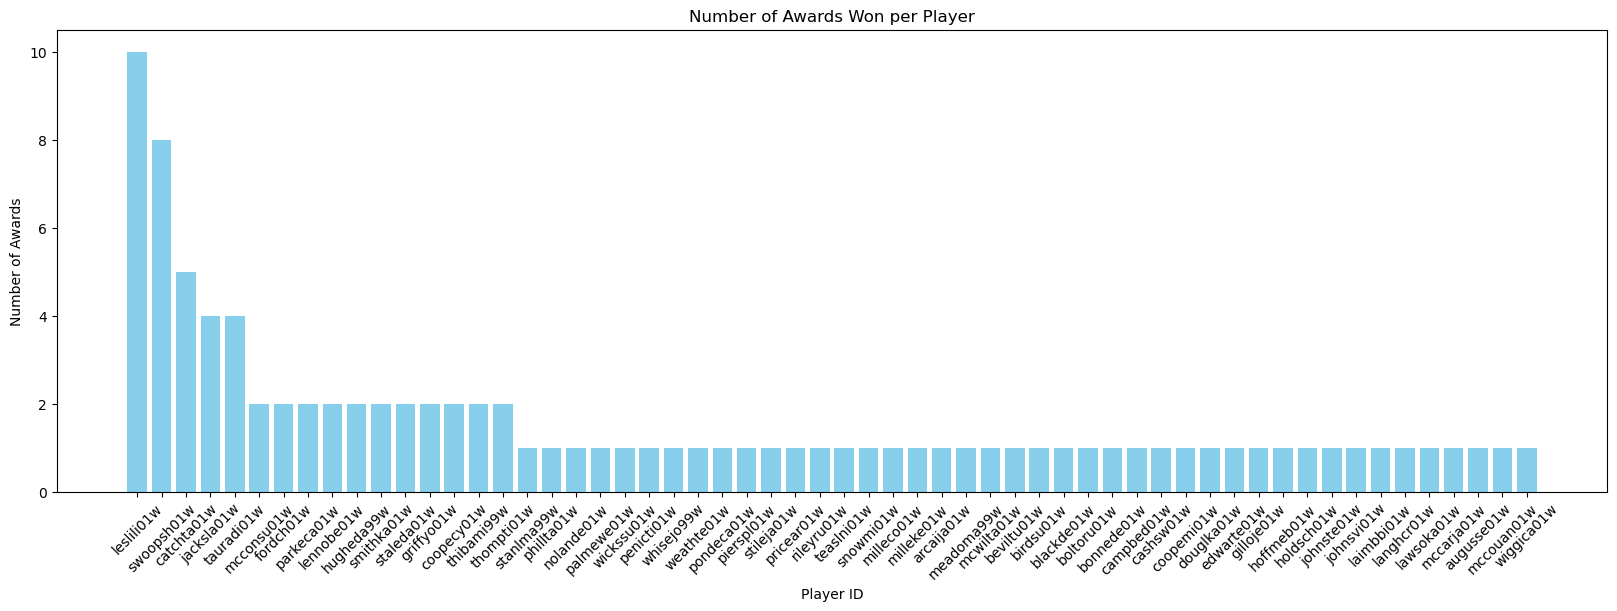

In [112]:
# Calculate the number of awards won per player
awards_count = pl_aw.groupby('playerID').size().reset_index(name='count')

# Sort by the count of awards in descending order
awards_count = awards_count.sort_values(by='count', ascending=False)

# Merge awards count with player attributes
merged_df = pd.merge(awards_count, pl_aw, on='playerID', how='inner')

# Create the plot
plt.figure(figsize=(20, 6))
plt.bar(merged_df['playerID'], merged_df['count'], color='skyblue')
plt.xlabel('Player ID')
plt.ylabel('Number of Awards')
plt.title('Number of Awards Won per Player')
plt.xticks(rotation=45)
plt.show()

In [113]:
# Plot weight and height in relation to playing position and awards won

def plot_weight_height_awards(merged_df, color_map, legend_column):
    # Scatter plots
    plt.figure(figsize=(15, 6))
    marker = 'o'

    merged_df = merged_df.sort_values(by=['weight', 'height'], ascending=[True, True])


    # Awards vs. Weight
    plt.subplot(1, 2, 1)
    for i, row in merged_df.iterrows():
        color = color_map[row[legend_column]]
        plt.scatter(row['count'], row['weight'], color=color, marker=marker, s=50, alpha=0.7)

    plt.xlabel('Number of Awards')
    plt.ylabel('Weight')
    plt.title('Awards vs. Weight')

    # Awards vs. Height
    plt.subplot(1, 2, 2)
    for i, row in merged_df.iterrows():
        color = color_map[row[legend_column]]
        plt.scatter(row['count'], row['height'], color=color, marker=marker, s=50, alpha=0.7)

    plt.xlabel('Number of Awards')
    plt.ylabel('Height')
    plt.title('Awards vs. Height')

    # Add a legend for positions
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=pos, 
                                markerfacecolor=color, markersize=10) for pos, color in color_map.items()]
    plt.legend(handles=legend_elements, title='Position', bbox_to_anchor=(1.2, 0), loc='lower right')

    plt.tight_layout()
    plt.show()

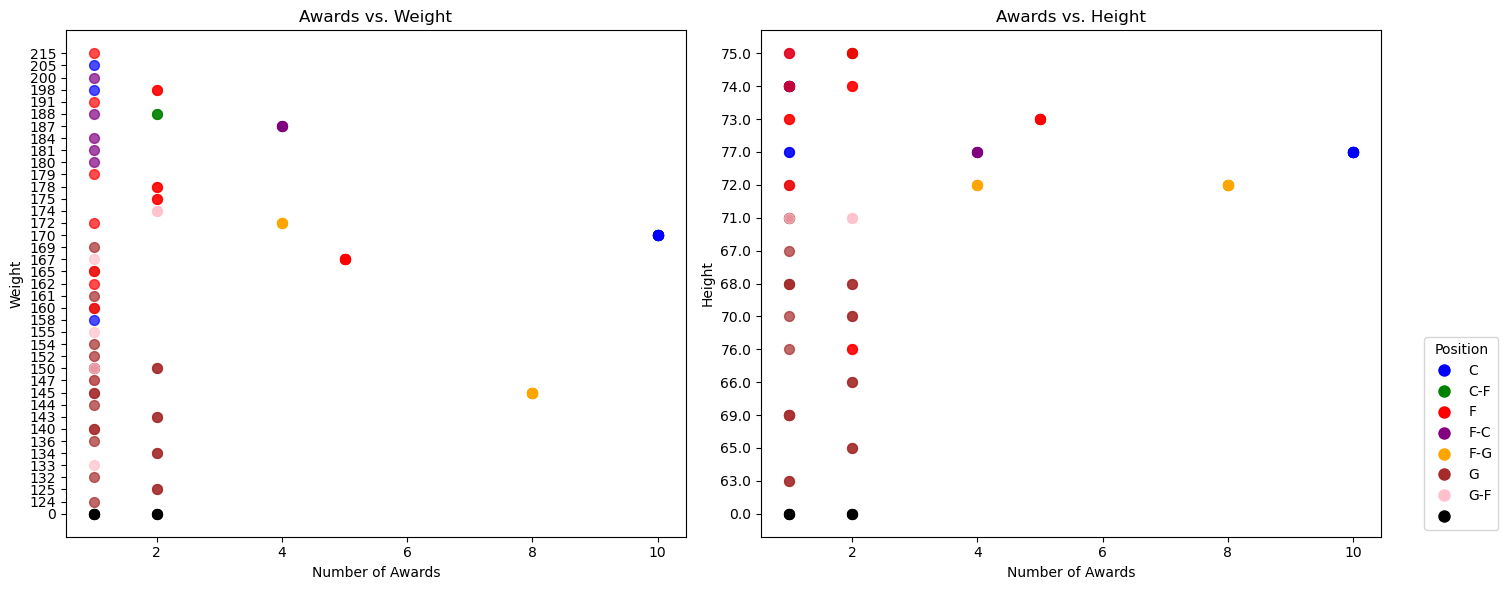

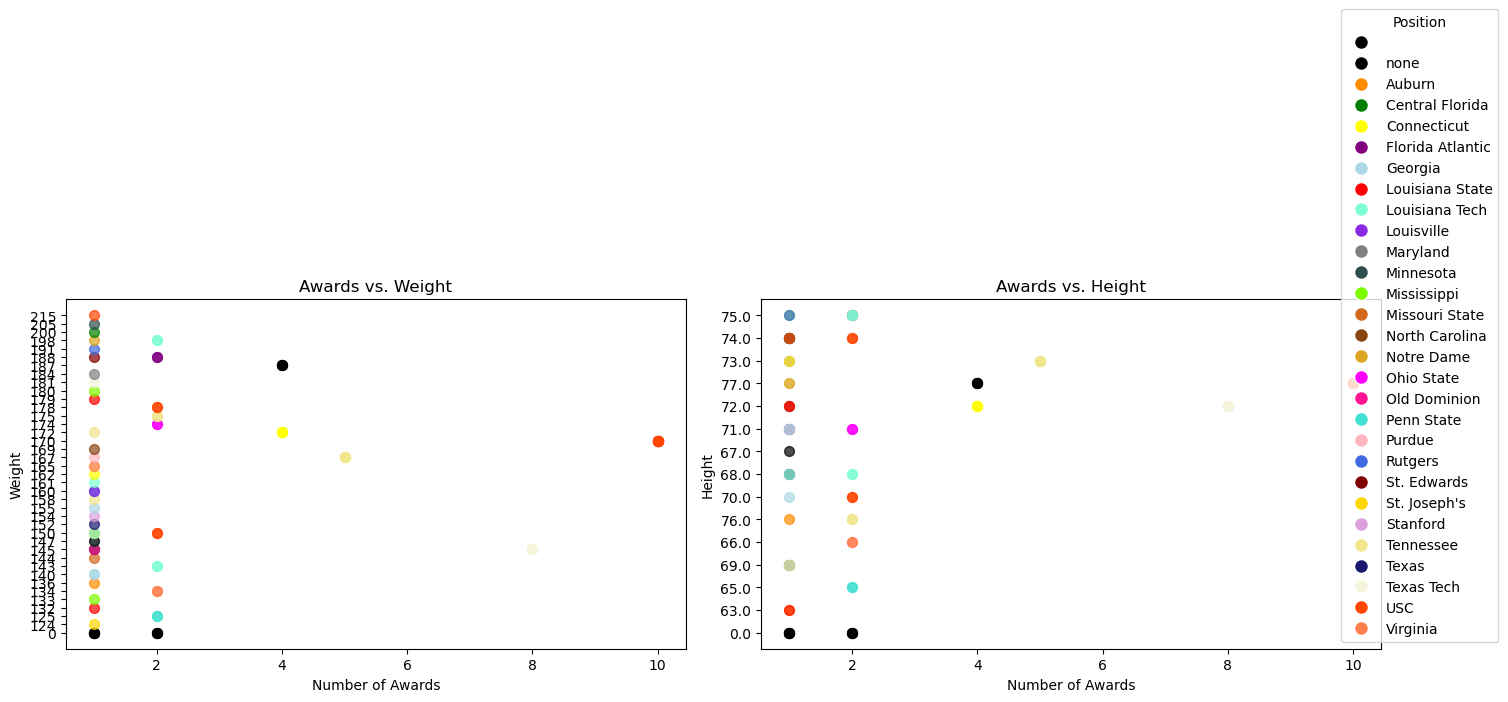

In [114]:

# Define custom color map for positions
pos_color_map = {
    'C': 'blue',
    'C-F': 'green',
    'F': 'red',
    'F-C': 'purple',
    'F-G': 'orange',
    'G': 'brown',
    'G-F': 'pink',
    '': 'black'
}

college_color_map = {
    '': 'black',
    'none': 'black',
    'Auburn': 'darkorange',
    'Central Florida': 'green',
    'Connecticut': 'yellow',
    'Florida Atlantic': 'purple',
    'Georgia':'lightblue',
    'Louisiana State': 'red',
    'Louisiana Tech': 'aquamarine',
    'Louisville': 'blueviolet',
    'Maryland': 'grey',
    'Minnesota': 'darkslategray',
    'Mississippi': 'lawngreen',
    'Missouri State': 'chocolate',
    'North Carolina': 'saddlebrown',
    'Notre Dame': 'goldenrod',
    'Ohio State': 'magenta',
    'Old Dominion': 'deeppink',
    'Penn State': 'turquoise',
    'Purdue': 'lightpink',
    'Rutgers': 'royalblue',
    'St. Edwards': 'maroon',
    "St. Joseph's": 'gold',
    'Stanford': 'plum',
    'Tennessee': 'khaki',
    'Texas': 'midnightblue',
    'Texas Tech': 'beige',
    'USC': 'orangered',
    'Virginia': 'coral'
 
}


plot_weight_height_awards(merged_df, pos_color_map, 'pos')
plot_weight_height_awards(merged_df, college_color_map, 'college')


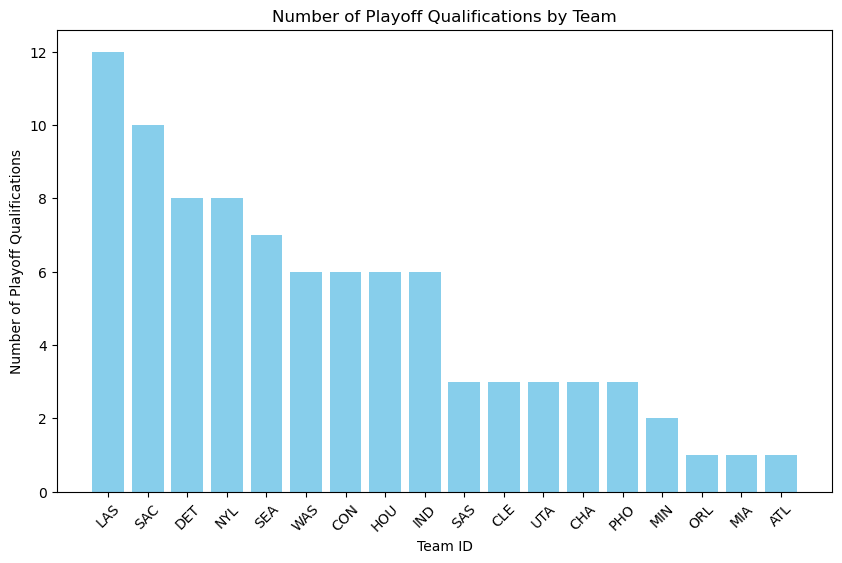

In [115]:
# Remove duplicate columns
cc_tm = cc_tm.loc[:,~cc_tm.columns.duplicated()].copy()

# Calculate the number of awards won per team
playoffs_count = cc_tm[cc_tm['playoff'] == 'Y'].groupby('tmID').size().reset_index(name='playoff_count')

playoffs_count = playoffs_count.sort_values(by='playoff_count', ascending=False)

# Merge awards count with player attributes
merged_df = pd.merge(awards_count, pl_aw, on='playerID', how='inner')

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(playoffs_count['tmID'], playoffs_count['playoff_count'], color='skyblue')
plt.xlabel('Team ID')
plt.ylabel('Number of Playoff Qualifications')
plt.title('Number of Playoff Qualifications by Team')
plt.xticks(rotation=45)
plt.show()



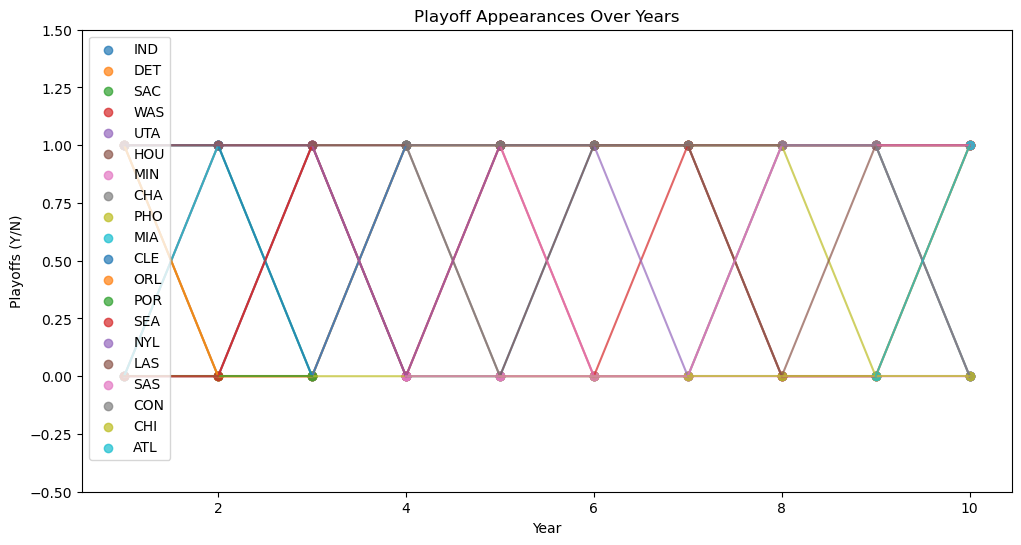

In [116]:
# Yearly performance graph (one line per team)

cc_tm['year'] = pd.to_numeric(cc_tm['year'], errors='coerce')

# Convert 'playoff' column to binary values (1 for 'Y', 0 for 'N')
cc_tm['playoff'] = (cc_tm['playoff'] == 'Y').astype(int)

# Sort DataFrame by 'year'
cc_tm.sort_values(by='year', inplace=True)

# Create a scatter plot
plt.figure(figsize=(12, 6))

# Loop through unique teams
for team in cc_tm['tmID'].unique():
    team_data = cc_tm[cc_tm['tmID'] == team]
    plt.scatter(team_data['year'], team_data['playoff'], label=team, alpha=0.7)
    plt.plot(team_data['year'], team_data['playoff'], alpha=0.7)

plt.xlabel('Year')
plt.ylabel('Playoffs (Y/N)')
plt.title('Playoff Appearances Over Years')
plt.ylim(-0.5, 1.5)
plt.legend(loc='upper left')
plt.show()

# TODO: fazer um plot um bocado mais legível
